## Credit Risk Modelling using Machine Learning

#### Saurabh Chatterjee

### Part - 1

This project aims to design a machine learning model to assess and predict *credit risk* with customer ranking by analyzing borrower profiles and historical data. 

## Introduction

- **Credit risk** is the probability of a financial loss resulting from a borrower's failure to repay a loan. Lenders can mitigate credit risk by analyzing factors about a borrower's creditworthiness, such as their current debt load and income. Using data driven approach with customer financial historical data features and leveraging machine learning, it is possible to accurately predict credit risk.

- Performed feature selection using statistical tests such as **Chi-Square** and **ANOVA**. Assessed Multicollinearity using **VIF**. Trained on several machine learning models with hyperparameter tuning.

**Problem Statement**: we have customer data. We are trying to predict whetehr or not give a loan.

### Banking:
#### (a) Assets:        (generates profit)(also called: Trade Line - TL)
- Housing loan
- Personal loan
- Vehicle loan
- Education loan, etc
- Credit Card **

#### (b) Liabilities:   (expenditure)
- Current account & Savings account: (Casa)
- Fixed Deposit & Recurring Deposit: (Term Deposits)

### NPA: Non-Performing Asset:
- Loan that is defaulted.

1. **Disbursed Amount**: Load amount given to a customer.
2. **OSP**: *Out Standing Principle* : amount of loan (balance) left to be paid. OSP should be zero at the end of loan cycle.
3. **DPD**: *Days Passed Due* : number of days passed after the <u>EMI due date</u>. DPD should be ideally zero. "Defaulted" if DPD > 0.
4. **PAR**: *Portfolio At Risk* : OSP when DPD > 0.  

5. **NPA**: Loan account when DPD > 90 days. 
 

### Credit Risk Types in Banking:

- DPD (Zero) : **NDA** (Non Delinquint Account)
- DPD (0 to 30) : **SMA1** (Standard Monitoring Account)
- DPD (31 to 60) : **SMA2** 
- DPD (61 to 90) : **SMA3** 
- DPD (91 to 180) : **NPA**
- DPD (> 180) : Written-off (loan which is not present): when too many days passed and load amount not returned. \
  (to improve NPA: Loan portfolio quality of the bank will be better = Market sentiment will be good)

### NPA Types:
1. **GNPA**: *Gross NPA* : OSP Defaulted - generally 3-5 % of OSP.
2. **NNPA**: *Net NPA* : After subtracting *Provisional Amount* from GNPA - generally 0.01-0.06% of OSP. \

Always assess a Bank quality using GNPA, not NNPA.

## Datasets

1. **CIBIL Dataset:** [case_study2.xlsx](data/case_study2.xlsx) : CIBIL Score Range: 350-900, above 750 is considered good. | 60 features + 1 Target variable |
- All banks send the customer's credit and payment history to **CIBIL** Bureau which determines the CIBIL Credit Score for the customer. \
Columns:
- Approved_Flag (**Target**) : Priority levels - P1, P2, P3, P4.




2. Product Dataset: [case_study1.xlsx](data/case_study1.xlsx) : Bank products (loan, etc) hold by the customer. | 25 features |

Total features = 60 + 25 = 85 features \
Feature Description: [Features_Target_Description.xlsx](data/Features_Target_Description.xlsx)

## Team Structure in a Company:
1. Data Science (ML, NLP, AI model developers)
2. MLOps (Deployment team, Cloud, AWS)
3. Data Engineering (Data Extractor)(ETL)
4. Business Team (loan product, marketing, HR, PR, Ops)
5. Distribution team (sales team)(Bank branch : send customer data to head branch, gets list of customers for loan approval)

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
import warnings
import os

In [2]:
# Load the dataset
a1 = pd.read_excel("case_study1.xlsx")
a2 = pd.read_excel("case_study2.xlsx")

df1 = a1.copy()     # Internal (Bank) Product Dataset: 26 features : 51336 rows
df2 = a2.copy()     # CIBIL Dataset : 62 features : 51336 rows

In [12]:
df1.head()

,PROSPECTID,Total_TL,Tot_Closed_TL,Tot_Active_TL,Total_TL_opened_L6M,Tot_TL_closed_L6M,pct_tl_open_L6M,pct_tl_closed_L6M,pct_active_tl,pct_closed_tl,...,CC_TL,Consumer_TL,Gold_TL,Home_TL,PL_TL,Secured_TL,Unsecured_TL,Other_TL,Age_Oldest_TL,Age_Newest_TL
0,1,5,4,1,0,0,0.000,0.0,0.200,0.800,...,0,0,1,0,4,1,4,0,72,18
1,2,1,0,1,0,0,0.000,0.0,1.000,0.000,...,0,1,0,0,0,0,1,0,7,7
2,3,8,0,8,1,0,0.125,0.0,1.000,0.000,...,0,6,1,0,0,2,6,0,47,2
3,4,1,0,1,1,0,1.000,0.0,1.000,0.000,...,0,0,0,0,0,0,1,1,5,5
4,5,3,2,1,0,0,0.000,0.0,0.333,0.667,...,0,0,0,0,0,3,0,2,131,32


In [13]:
df2.head()

,PROSPECTID,time_since_recent_payment,time_since_first_deliquency,time_since_recent_deliquency,num_times_delinquent,max_delinquency_level,max_recent_level_of_deliq,num_deliq_6mts,num_deliq_12mts,num_deliq_6_12mts,...,pct_CC_enq_L6m_of_L12m,pct_PL_enq_L6m_of_ever,pct_CC_enq_L6m_of_ever,max_unsec_exposure_inPct,HL_Flag,GL_Flag,last_prod_enq2,first_prod_enq2,Credit_Score,Approved_Flag
0,1,549,35,15,11,29,29,0,0,0,...,0.0,0.0,0.0,13.333,1,0,PL,PL,696,P2
1,2,47,-99999,-99999,0,-99999,0,0,0,0,...,0.0,0.0,0.0,0.860,0,0,ConsumerLoan,ConsumerLoan,685,P2
2,3,302,11,3,9,25,25,1,9,8,...,0.0,0.0,0.0,5741.667,1,0,ConsumerLoan,others,693,P2
3,4,-99999,-99999,-99999,0,-99999,0,0,0,0,...,0.0,0.0,0.0,9.900,0,0,others,others,673,P2
4,5,583,-99999,-99999,0,-99999,0,0,0,0,...,0.0,0.0,0.0,-99999.000,0,0,AL,AL,753,P1


### Credit Score Range for each Priority Level

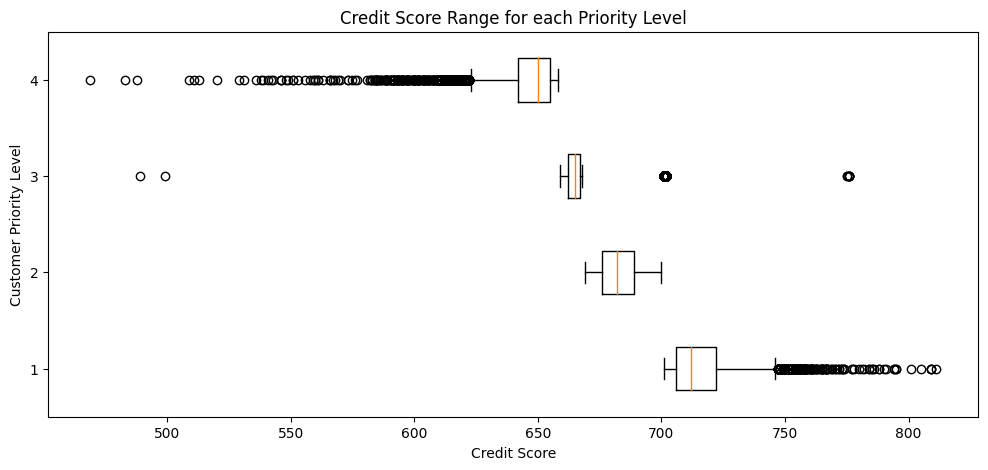

In [14]:
credit_score_p1 = df2['Credit_Score'].loc[df2['Approved_Flag']=='P1']
credit_score_p2 = df2['Credit_Score'].loc[df2['Approved_Flag']=='P2']
credit_score_p3 = df2['Credit_Score'].loc[df2['Approved_Flag']=='P3']
credit_score_p4 =  df2['Credit_Score'].loc[df2['Approved_Flag']=='P4']

credit_score_ranks = [credit_score_p1, credit_score_p2, credit_score_p3, credit_score_p4]

fig = plt.figure(figsize=(12, 5))

plt.boxplot(credit_score_ranks, vert=0)
plt.xlabel("Credit Score")
plt.ylabel("Customer Priority Level")
plt.title("Credit Score Range for each Priority Level")
plt.show()

## Feature Engineering

In [14]:
# Remove NULLS:
# df1:
df1 = df1.loc[df1['Age_Oldest_TL'] != -99999]       # Dropping Rows: since 'Age_Oldest_TL' rows with value -99999 are less than 50 << 51336
print("df1 shape: ", df1.shape)                     # (51296, 26)
print("No. of Null values in df1 = ", df1.isna().sum())


# df2:  this dataset features has too many Null values in most of the features. 
# Now instead of Imputation (mean/median/other, which ultimately is an assumption which may be far from True, so don't want to use this): 
# if number of Null rows (value = -99999):
# (1) < 10,000 : Remove the Rows
# (2) > 10,000 : Remove the Column / feature

columns_to_be_removed = []

for i in df2.columns:
    if df2.loc[df2[i] == -99999].shape[0] > 10000:
        columns_to_be_removed .append(i)

print("Columns to be removed: ", columns_to_be_removed)

df2 = df2.drop(columns_to_be_removed, axis =1)      # Dropping the Columns with no. of Null rows > 10,000 

for i in df2.columns:
    df2 = df2.loc[ df2[i] != -99999 ]               # Dropping the Null Rows in the remaining Cols (where no. of Null rows < 10,000) 

print("No. of Null values in df2 = ", df2.isna().sum())

print("Final df2 shape: ", df2.shape)               # (42066, 54)

df1 shape:  (51296, 26)
Columns to be removed:  ['time_since_first_deliquency', 'time_since_recent_deliquency', 'max_delinquency_level', 'max_deliq_6mts', 'max_deliq_12mts', 'CC_utilization', 'PL_utilization', 'max_unsec_exposure_inPct']
Final df2 shape:  (42066, 54)


In [17]:
# Checking common column names: for Common User ID : to perform MERGE Dataframes
for i in list(df1.columns):
    if i in list(df2.columns):
        print ("Common Column to act as User ID for Merging: ", i)

Common Column to act as User ID for Merging:  PROSPECTID


In [25]:
# Merging the two Dataframes, INNER JOIN: so that no Nulls are present
df = pd. merge ( df1, df2, how ='inner', left_on = ['PROSPECTID'], right_on = ['PROSPECTID'] )
df.head()           # total 79 features

,PROSPECTID,Total_TL,Tot_Closed_TL,Tot_Active_TL,Total_TL_opened_L6M,Tot_TL_closed_L6M,pct_tl_open_L6M,pct_tl_closed_L6M,pct_active_tl,pct_closed_tl,...,pct_PL_enq_L6m_of_L12m,pct_CC_enq_L6m_of_L12m,pct_PL_enq_L6m_of_ever,pct_CC_enq_L6m_of_ever,HL_Flag,GL_Flag,last_prod_enq2,first_prod_enq2,Credit_Score,Approved_Flag
0,1,5,4,1,0,0,0.000,0.0,0.200,0.800,...,0.0,0.0,0.000,0.0,1,0,PL,PL,696,P2
1,2,1,0,1,0,0,0.000,0.0,1.000,0.000,...,0.0,0.0,0.000,0.0,0,0,ConsumerLoan,ConsumerLoan,685,P2
2,3,8,0,8,1,0,0.125,0.0,1.000,0.000,...,0.0,0.0,0.000,0.0,1,0,ConsumerLoan,others,693,P2
3,5,3,2,1,0,0,0.000,0.0,0.333,0.667,...,0.0,0.0,0.000,0.0,0,0,AL,AL,753,P1
4,6,6,5,1,0,0,0.000,0.0,0.167,0.833,...,1.0,0.0,0.429,0.0,1,0,ConsumerLoan,PL,668,P3


### Categorical Features

In [34]:
# First analysing the Categorical Features:
# check how many columns are categorical
for i in df.columns:
    if df[i].dtype == 'object':
        print(i)

print('\n')
print("MARITALSTATUS: \n", df['MARITALSTATUS'].value_counts(), '\n')
print("EDUCATION: \n", df['EDUCATION'].value_counts(), '\n')
print("GENDER: \n", df['GENDER'].value_counts(), '\n')
print("last_prod_enq2: \n", df['last_prod_enq2'].value_counts(), '\n')
print("first_prod_enq2: \n", df['first_prod_enq2'].value_counts(), '\n')

# 'Approved_Flag' is the Target variable : P1, P2, P3, P4 (Priority levels)

MARITALSTATUS
EDUCATION
GENDER
last_prod_enq2
first_prod_enq2
Approved_Flag


MARITALSTATUS: 
 MARITALSTATUS
Married    30886
Single     11178
Name: count, dtype: int64 

EDUCATION: 
 EDUCATION
GRADUATE          14140
12TH              11703
SSC                7241
UNDER GRADUATE     4572
OTHERS             2291
POST-GRADUATE      1898
PROFESSIONAL        219
Name: count, dtype: int64 

GENDER: 
 GENDER
M    37345
F     4719
Name: count, dtype: int64 

last_prod_enq2: 
 last_prod_enq2
ConsumerLoan    16480
others          13653
PL               7553
CC               2195
AL               1353
HL                830
Name: count, dtype: int64 

first_prod_enq2: 
 first_prod_enq2
others          20640
ConsumerLoan    11075
PL               4431
AL               2641
CC               1988
HL               1289
Name: count, dtype: int64 



#### 'MARITALSTATUS' vs 'Approved_Flag':
'MARITALSTATUS': Single / Married **|** 'Approved_Flag': P1/P2/P3/P4 **|** Both are Categorical variables. \
How to determine are they associated ? : 
- Shall it be converted into Numerical values (Label/Ordinal Encoding) ? NO because it is used in Ordinal features where categories have some ranking.
- One-Hot encoding can be done.
- Chi-Sqaure test : BETTER 

## Feature Selection

1. **Hypothesis Testing**: \
Are these two are associated: MARITALSTATUS and Approved_Flag ? \
**H0: Null hypothesis :** Not associated \
**H1: Alternative hypothesis :** Associated

2. **alpha** : *Significance level* / *Margin of Error* (how much the estimate can be wrong): Assumed : = **0.05**
- less risky projects : high alpha
- high risky projects : low alpha

3. **Confidence Interval** = (1-**alpha**)

4. Calculate the evidence against H0 : **p-value** 
- calculate using tests : T-test, Chi-Square test, ANOVA based on *degree of freedom*. If:
- **p-value** <= **alpha** : Reject H0
- **p-value** > **alpha** : Fail to Reject H0  
(not saying Accept H0 because we don't have enough evidence of it being True either, we just failed to prove it is False: in actual it may or may not be False. The conclusion is based on our defined confidence interval).

When to use what test :
- **Chi-Square** test: Categorical vs Categorical
- **T-test**: Categorical vs Numerical (2 categories)
- **ANOVA**: Categorical vs Numerical (>2 categories)

### Categorical Feature Selection:
- To determine which categorical features are associated with the Target variable.
- Estimate **Chi-Sqaure** test : get **p-value** for each feature.
- Keep only those features whose **p-value** < **alpha** (0.05).

In [36]:
# Chi-Square test:
for i in ['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2']:
    chi2, pval, _, _ = chi2_contingency(pd.crosstab(df[i], df['Approved_Flag']))
    print(i, '---', pval)       # print p-values

# since all the Categorical features have p-value <= 0.05, we will keep them all.

MARITALSTATUS --- 3.578180861038862e-233
EDUCATION --- 2.6942265249737532e-30
GENDER --- 1.907936100186563e-05
last_prod_enq2 --- 0.0
first_prod_enq2 --- 7.84997610555419e-287


### Numerical Features

In [38]:
# check how many columns are Numerical:
numeric_columns = []
for i in df.columns:
    if df[i].dtype != 'object' and i not in ['PROSPECTID','Approved_Flag']:
        numeric_columns.append(i)

numeric_columns

['Total_TL',
 'Tot_Closed_TL',
 'Tot_Active_TL',
 'Total_TL_opened_L6M',
 'Tot_TL_closed_L6M',
 'pct_tl_open_L6M',
 'pct_tl_closed_L6M',
 'pct_active_tl',
 'pct_closed_tl',
 'Total_TL_opened_L12M',
 'Tot_TL_closed_L12M',
 'pct_tl_open_L12M',
 'pct_tl_closed_L12M',
 'Tot_Missed_Pmnt',
 'Auto_TL',
 'CC_TL',
 'Consumer_TL',
 'Gold_TL',
 'Home_TL',
 'PL_TL',
 'Secured_TL',
 'Unsecured_TL',
 'Other_TL',
 'Age_Oldest_TL',
 'Age_Newest_TL',
 'time_since_recent_payment',
 'num_times_delinquent',
 'max_recent_level_of_deliq',
 'num_deliq_6mts',
 'num_deliq_12mts',
 'num_deliq_6_12mts',
 'num_times_30p_dpd',
 'num_times_60p_dpd',
 'num_std',
 'num_std_6mts',
 'num_std_12mts',
 'num_sub',
 'num_sub_6mts',
 'num_sub_12mts',
 'num_dbt',
 'num_dbt_6mts',
 'num_dbt_12mts',
 'num_lss',
 'num_lss_6mts',
 'num_lss_12mts',
 'recent_level_of_deliq',
 'tot_enq',
 'CC_enq',
 'CC_enq_L6m',
 'CC_enq_L12m',
 'PL_enq',
 'PL_enq_L6m',
 'PL_enq_L12m',
 'time_since_recent_enq',
 'enq_L12m',
 'enq_L6m',
 'enq_L3m',

### Numerical Feature Selection:
- To determine which numerical features are associated with the Target variable.
- Test to be done : **ANOVA** (since Target varible: 'Approved_Flag' has > 2 categories).
- But before performing ANOVA, **Multicollinearity** between the feature variables needs to be determined : **VIF (Variance Inflation Factor)**.

#### Multicollinearity vs Correlation
- **Multicollinearity** : When two or more features are high associated. Predictability of each feature by other features.
- **Correlation** : It is specific to linear relationship between columns. 
- When we are not sure of whether the feature should have linear relationship or not (because of lack of domain knowledge) : it's safer to use **VIF** rather than Correlation.

#### **VIF (Variance Inflation Factor)**:
- Used to identify Multicollinearity among independent features.
- VIF<sub>i</sub> = 1 / (1- R<sub>i</sub><sup>2</sup>), where R<sub>i</sub><sup>2</sup> is the *coefficient of determination**.
- if VIF<sub>i</sub> > 6 : Highly Multicollinear with other features : remove that feature variable.

VIF: Sequential vs Parallel method:
- Sequentially - Correct method : one out of the several multicollinear features are kept.
- Parallel - Incorrect method : all of the multicollinear features are dropped.

In [42]:
# VIF sequentially check

vif_data = df[numeric_columns]          # Numerical Columns
total_columns = vif_data.shape[1]       # no. of numerical cols
columns_to_be_kept = []                 # Numerical Columns to be kept
column_index = 0

for i in range (0, total_columns):
    
    vif_value = variance_inflation_factor(vif_data, column_index)       # VIF of ith feature column
    print (column_index,'---',vif_value)
    
    
    if vif_value <= 6:
        columns_to_be_kept.append( numeric_columns[i] )                 # if VIF <= 6: keep the feature
        column_index = column_index+1
    
    else:
        vif_data = vif_data.drop([ numeric_columns[i] ] , axis=1)       # else drop the feature: (SEQUENTIAL VIF)

len(columns_to_be_kept)         # No. of Numerical Columns to be kept (out of 72) = 39

c:\Users\Saurabh Chatterjee\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


0 --- inf


c:\Users\Saurabh Chatterjee\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


0 --- inf
0 --- 11.320180023967996
0 --- 8.363698035000327
0 --- 6.520647877790928
0 --- 5.149501618212625
1 --- 2.611111040579735


c:\Users\Saurabh Chatterjee\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


2 --- inf
2 --- 1788.7926256209232
2 --- 8.601028256477228
2 --- 3.8328007921530785
3 --- 6.0996533816467355
3 --- 5.581352009642762
4 --- 1.9855843530987785


c:\Users\Saurabh Chatterjee\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


5 --- inf
5 --- 4.809538302819343
6 --- 23.270628983464636
6 --- 30.595522588100053
6 --- 4.3843464059655854
7 --- 3.064658415523423
8 --- 2.898639771299252
9 --- 4.377876915347322
10 --- 2.2078535836958433
11 --- 4.916914200506864
12 --- 5.214702030064725
13 --- 3.3861625024231476
14 --- 7.840583309478997
14 --- 5.255034641721438


c:\Users\Saurabh Chatterjee\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


15 --- inf
15 --- 7.380634506427232
15 --- 1.421005001517573
16 --- 8.083255010190323
16 --- 1.6241227524040114
17 --- 7.257811920140003
17 --- 15.59624383268298
17 --- 1.825857047132431
18 --- 1.5080839450032664
19 --- 2.172088834824578
20 --- 2.623397553527229
21 --- 2.2959970812106167
22 --- 7.360578319196439
22 --- 2.1602387773102554
23 --- 2.8686288267891467
24 --- 6.458218003637277
24 --- 2.8474118865638265
25 --- 4.753198156284083
26 --- 16.22735475594825
26 --- 6.424377256363877
26 --- 8.887080381808687
26 --- 2.3804746142952653
27 --- 8.609513476514548
27 --- 13.06755093547673
27 --- 3.500040056654654
28 --- 1.908795587481377
29 --- 17.006562234161628
29 --- 10.730485153719197
29 --- 2.3538497522950275
30 --- 22.104855915136433
30 --- 2.7971639638512924
31 --- 3.424171203217696
32 --- 10.175021454450935
32 --- 6.408710354561301
32 --- 1.0011511962625619
33 --- 3.069197305397274
34 --- 2.8091261600643724
35 --- 20.249538381980678
35 --- 15.864576541593774
35 --- 1.8331649740532

39

In [43]:
# check ANOVA for columns_to_be_kept : determine which Numerical Columns are associated with the Target variable 'Approved_Flag'

from scipy.stats import f_oneway

columns_to_be_kept_numerical = []       # Final Numerical Columns to be kept

for i in columns_to_be_kept:
    a = list(df[i])  
    b = list(df['Approved_Flag'])  
    
    # dividing the feature values into four groups for each of the Target variable category:
    group_P1 = [value for value, group in zip(a, b) if group == 'P1']
    group_P2 = [value for value, group in zip(a, b) if group == 'P2']
    group_P3 = [value for value, group in zip(a, b) if group == 'P3']
    group_P4 = [value for value, group in zip(a, b) if group == 'P4']


    f_statistic, p_value = f_oneway(group_P1, group_P2, group_P3, group_P4)     # One-way ANOVA

    if p_value <= 0.05:
        columns_to_be_kept_numerical.append(i)      # keep the feature if the p-value is <= 0.05

In [44]:
# listing all the final features:

features = columns_to_be_kept_numerical + ['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2']
df = df[features + ['Approved_Flag']]

df.to_excel("data/final_filtered_dataset.xlsx")